In [1]:
!pip install keras-cv tensorflow

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import numpy as np
import matplotlib.pyplot as plt
# from yolov4.tf import YOLOv4  # Assume you have a TensorFlow implementation
import h5py
from sklearn.model_selection import train_test_split
import seaborn as sns
import keras_cv

tf.config.optimizer.set_experimental_options({"cudnn_deterministic": True})

seed = 42
# Set seed for TensorFlow
# tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)

# Check Available GPUs
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 22.1 MB/s eta 0:00:00
Num GPUs Available: 1


In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/NAML_project/

Mounted at /gdrive
/gdrive/My Drive/NAML_project


In [3]:
# input_dataset_filepath = "../input/mel-spectogram/mel_spectrograms.h5"   # for Kaggle
input_dataset_filepath = "mel_spectrograms.h5"   # for Colab

with h5py.File(input_dataset_filepath, "r") as f:
    X = f["images"][:]
    labels = f["labels"][:]

labels_map = {
    0: 'blues',
    1: 'classical',
    2: 'country',
    3: 'disco',
    4: 'hiphop',
    5: 'jazz',
    6: 'metal',
    7: 'pop',
    8: 'reggae',
    9: 'rock'
}


(1000, 416, 416, 3) (1000,)


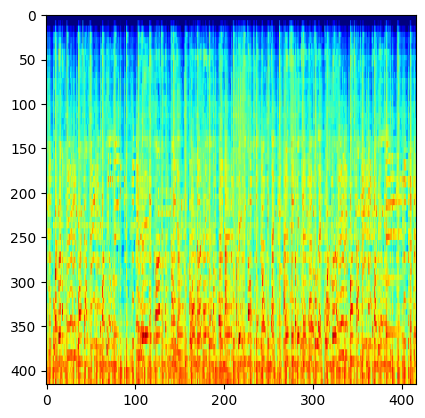

class 0: # 100 samples
class 1: # 100 samples
class 2: # 100 samples
class 3: # 100 samples
class 4: # 100 samples
class 5: # 100 samples
class 6: # 100 samples
class 7: # 100 samples
class 8: # 100 samples


In [4]:
print(X.shape, labels.shape)
input_shape = X.shape[1:]

plt.imshow(X[0])
plt.show()
for i in range(9):
    print(f'class {i}: # {labels[labels==i].shape[0]} samples')

In [5]:
# Split the paths (not the data) into training, validation, and test sets
print("Splitting data...")
X_val, X_test, y_val, y_test = train_test_split(
    X, labels, test_size=100, random_state=seed
)
X_train, X_val, y_train, y_val = train_test_split(
    X_val, y_val, test_size=100, random_state=seed
)
print("Data splitted!")

print(f"\nNumber of images:")
print(f"Train: {X_train.shape}")
print('\t', y_train.shape)
print(f"Validation: {X_val.shape}")
print('\t', y_val.shape)
print(f"Test: {X_test.shape}")
print('\t', y_test.shape)

Splitting data...
Data splitted!

Number of images:
Train: (800, 416, 416, 3)
	 (800,)
Validation: (100, 416, 416, 3)
	 (100,)
Test: (100, 416, 416, 3)
	 (100,)


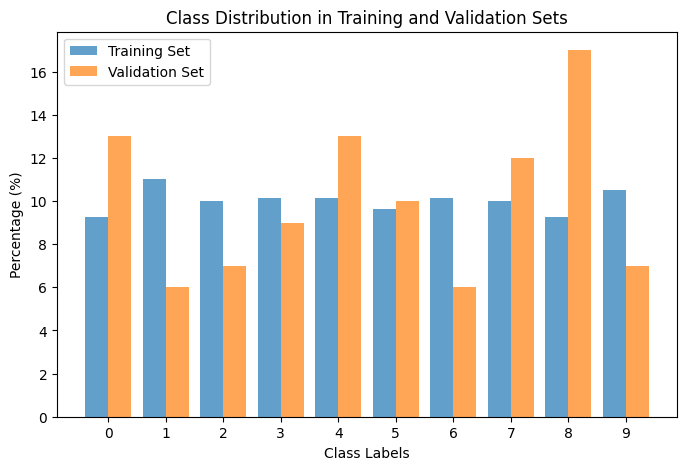

In [6]:
from collections import Counter

# Count occurrences of each class
train_counts = Counter(y_train)
val_counts = Counter(y_val)

# Convert to percentages
classes = sorted(set(y_train) | set(y_val))  # Unique classes
train_values = [(train_counts[c] / len(y_train)) * 100 for c in classes]
val_values = [(val_counts[c] / len(y_val)) * 100 for c in classes]

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.4
x_indexes = np.arange(len(classes))

plt.bar(x_indexes - bar_width/2, train_values, bar_width, label="Training Set", alpha=0.7)
plt.bar(x_indexes + bar_width/2, val_values, bar_width, label="Validation Set", alpha=0.7)

plt.xlabel("Class Labels")
plt.ylabel("Percentage (%)")
plt.title("Class Distribution in Training and Validation Sets")
plt.xticks(ticks=x_indexes, labels=classes)
plt.legend()
plt.show()

In [7]:
# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
y_test = tfk.utils.to_categorical(y_test)

# Compare categorical label and "default" label representation
# Display the categorical label
print('Categorical label:', y_train[0])
# Display the equivalent numeric label
print('"Default" label:', np.argmax(y_train[0]))

Categorical label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
"Default" label: 7


In [8]:
class MacroPrecision(tf.keras.metrics.Metric):
    def __init__(self, name="macro_precision", num_classes=10, **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.precisions = [tf.keras.metrics.Precision() for _ in range(num_classes)]

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_classes = tf.argmax(y_true, axis=1)
        y_pred_classes = tf.argmax(y_pred, axis=1)

        for i in range(self.num_classes):
            y_true_i = tf.cast(y_true_classes == i, tf.int32)
            y_pred_i = tf.cast(y_pred_classes == i, tf.int32)
            self.precisions[i].update_state(y_true_i, y_pred_i)

    def result(self):
        return tf.reduce_mean([p.result() for p in self.precisions])

    def reset_state(self):
        for p in self.precisions:
            p.reset_state()




### Da https://github.com/mbonyani/DropBlock-tf/blob/main/utils/DropBlock.py
from tensorflow.keras import backend as K
def _bernoulli(shape, mean):
    return tf.nn.relu(tf.sign(mean - tf.random.uniform(shape, minval=0, maxval=1, dtype=tf.float32)))

class DropBlock2D(tf.keras.layers.Layer):
    def __init__(self, keep_prob, block_size, scale=True,name=None, **kwargs):
        super(DropBlock2D, self).__init__(name="DropBlock2D")
        self.keep_prob = float(keep_prob) if isinstance(keep_prob, int) else keep_prob
        self.block_size = int(block_size)
        self.names = name
        self.scale = tf.constant(scale, dtype=tf.bool) if isinstance(scale, bool) else scale
        super(DropBlock2D, self).__init__(**kwargs)

    def get_config(self):
        config = super().get_config().copy()
        config.update( {"block_size": self.block_size,"keep_prob": self.keep_prob,"name": self.names })
        return config

    def compute_output_shape(self, input_shape):
        return input_shape

    def build(self, input_shape):
        assert len(input_shape) == 4
        _, self.h, self.w, self.channel = input_shape    #.as_list()
        # pad the mask
        p1 = (self.block_size - 1) // 2
        p0 = (self.block_size - 1) - p1
        self.padding = [[0, 0], [p0, p1], [p0, p1], [0, 0]]
        self.set_keep_prob()
        super(DropBlock2D, self).build(input_shape)

    def call(self, inputs, training=None, **kwargs):
        def drop():
            mask = self._create_mask(tf.shape(inputs))
            output = inputs * mask
            output = tf.cond(self.scale,
                             true_fn=lambda: output *tf.cast(tf.size(mask), dtype=tf.float32)  / tf.reduce_sum(mask),
                             false_fn=lambda: output)
            return output

        if training is None:
            training = K.learning_phase()
        output = tf.cond(tf.logical_or(tf.logical_not(training), tf.equal(self.keep_prob, 1.0)),
                         true_fn=lambda: inputs,
                         false_fn=drop)
        return output

    def set_keep_prob(self, keep_prob=None):
        """This method only supports Eager Execution"""
        if keep_prob is not None:
            self.keep_prob = keep_prob
        w, h = tf.cast(self.w, dtype=tf.float32), tf.cast(self.h, dtype=tf.float32)

        self.gamma = (1. - self.keep_prob) * (w * h) / (self.block_size ** 2) / \
                     ((w - self.block_size + 1) * (h - self.block_size + 1))

    def _create_mask(self, input_shape):
        sampling_mask_shape = tf.stack([input_shape[0],
                                       self.h - self.block_size + 1,
                                       self.w - self.block_size + 1,
                                       self.channel])
        mask = _bernoulli(sampling_mask_shape, self.gamma)
        mask = tf.pad(mask, self.padding)
        mask = tf.nn.max_pool(mask, [1, self.block_size, self.block_size, 1], [1, 1, 1, 1], 'SAME')
        mask = 1 - mask
        return mask




class SaveModelAtEpochEnd(tf.keras.callbacks.Callback):
    def __init__(self, save_dir, model_name="model_epoch"):
        super(SaveModelAtEpochEnd, self).__init__()
        self.save_dir = save_dir
        self.model_name = model_name

    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 10 == 0:
            # Construct the file path where the model will be saved
            save_path = f"{self.save_dir}/{self.model_name}_onepochend.weights.h5"

            # Save the model
            self.model.save_weights(save_path)
            # print(f"Model saved at epoch {epoch + 1}: {save_path}")

In [9]:
# Define input layer with shape matching the input images
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_l_backbone_coco",
    load_weights=True
)
inputs = tfk.Input(shape=input_shape, name='input_layer')
x = backbone(inputs)

# Freeze all layers in ResNET to use it solely as a feature extractor
backbone.trainable = True

# n_conv = 1
# # Enable training only for Conv2D and DepthwiseConv2D layers
# for i, layer in enumerate(backbone.layers):
#     x = layer(x.output)
#     if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
#         layer.trainable = True
#         # if n_conv % 9 == 0:
#         #     x = DropBlock2D(0.90 - (n_conv//9)*0.2, (n_conv//9)*3)(x)
#         n_conv += 1
# print(n_layers_trainable)

# Add dropout layers for regularisation and a GAP Layer to reduce trainable Parameters
# x = tfkl.Dropout(0.3, name='dropout')(x)
x = tfkl.GlobalAveragePooling2D(name='GAP')(x)
# x = tfkl.Dropout(0.1, name='dropout2')(x)

# Add some dense layers, with dropout
x = tfkl.Dense(256, activation='relu', name='fc1')(x)
x = tfkl.BatchNormalization(name='classification_bn1')(x)
x = tfkl.Dropout(0.2, name='dropout1')(x)

x = tfkl.Dense(128, activation='relu', name='fc2')(x)
x = tfkl.BatchNormalization(name='classification_bn2')(x)
x = tfkl.Dropout(0.2, name='dropout2')(x)

x = tfkl.Dense(128, activation='relu', name='fc3')(x)
x = tfkl.BatchNormalization(name='classification_bn3')(x)
x = tfkl.Dropout(0.2, name='dropout3')(x)

x = tfkl.Dense(64, activation='relu', name='fc4')(x)
x = tfkl.BatchNormalization(name='classification_bn4')(x)
# x = tfkl.Dropout(0.05, name='dropout4')(x)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(10, activation='softmax', name='dense')(x)

# Define the complete model linking input and output
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with categorical cross-entropy loss and AdamW optimiser
model.compile(
    loss=tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(learning_rate = 1e-4),
    metrics=[MacroPrecision()]
)

# Display a summary of the model architecture
model.summary(expand_nested=False)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 416, 416, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ yolov8_backbone (YOLOV8Backbone)     │ (None, 13, 13, 512)         │      19,831,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GAP (GlobalAveragePooling2D)         │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_bn1                   │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout1 (Dropout)                   │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc2 (Dense)                          │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_bn2                   │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout2 (Dropout)                   │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc3 (Dense)                          │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_bn3                   │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout3 (Dropout)                   │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc4 (Dense)                          │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_bn4                   │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,023,690 (76.38 MB)

 Trainable params: 19,999,370 (76.29 MB)

 Non-trainable params: 24,320 (95.00 KB)

In [10]:
from tensorflow.keras.utils import plot_model

# plot_model(model, to_file="yolov4_model.png", show_shapes=True, show_layer_names=True)

# Define the directory to save models
save_dir = "/kaggle/working/"
# Create the custom callback
save_model_callback = SaveModelAtEpochEnd(save_dir)

In [11]:
%cd /gdrive/My Drive/NAML_project/17
model.load_weights('yolov8_very_bigger_classification_71.74.weights.h5')

/gdrive/My Drive/NAML_project/17


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 344 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Results after training

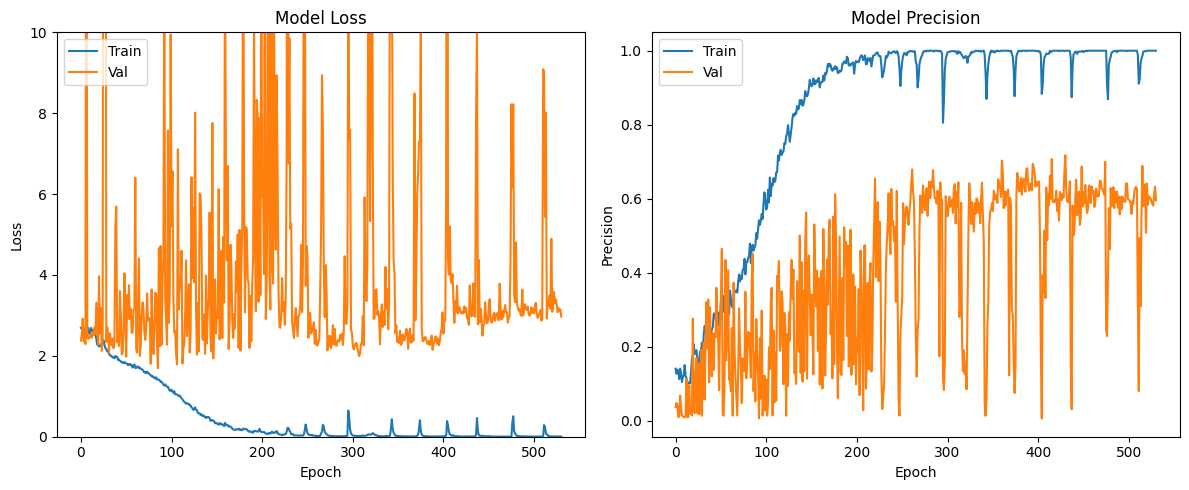

In [12]:
import json
# Read JSON from a file
with open('history_71.74_final_acc.txt', 'r') as file:
    data = json.load(file)  # Convert JSON to Python dictionary


fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create 1 row, 2 columns of subplots

# Plot model loss
axes[0].plot(data['loss'])
axes[0].plot(data['val_loss'])
axes[0].set_title('Model Loss')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylim(top=10, bottom=0)  # Set the maximum y-limit to 10
axes[0].legend(['Train', 'Val'], loc='upper left')

# Plot model precision
axes[1].plot(data['macro_precision'])
axes[1].plot(data['val_macro_precision'])
axes[1].set_title('Model Precision')
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step
Accuracy score over the test set: 0.46
Precision score over the test set: 0.5162
Recall score over the test set: 0.46
F1 score over the test set: 0.4594


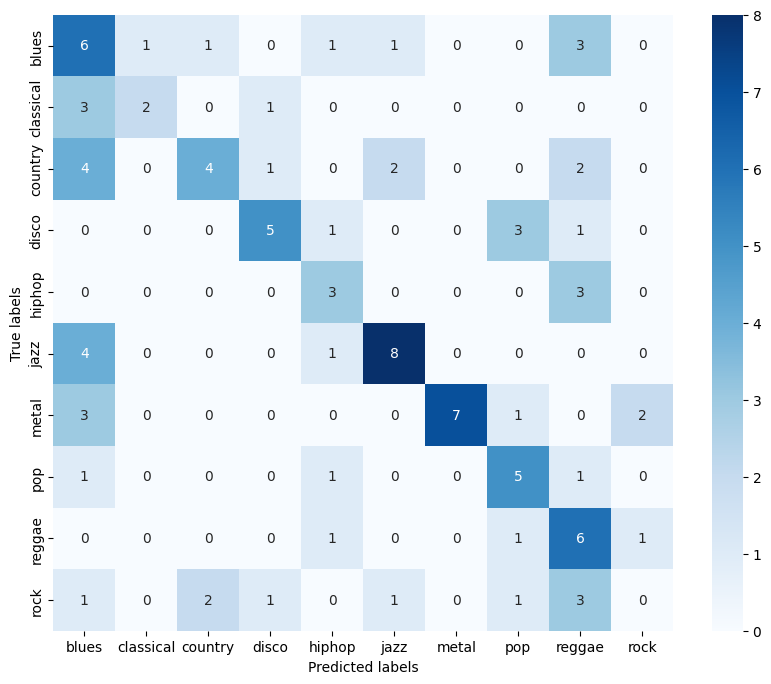

TP
[6 2 4 5 3 8 7 5 6 0]
FP
[16  1  3  3  5  4  0  6 13  3]
FN
[7 4 9 5 3 5 6 3 3 9]
TN
[71 93 84 87 89 83 87 86 78 88]


In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

model.training = False
predictions = model.predict(X_test)

# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=annot, fmt='', xticklabels=list(labels_map.values()), yticklabels=list(labels_map.values()), cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (TP + FP + FN)

print('TP', TP,'FP', FP, 'FN', FN, 'TN', TN, sep='\n')